# Import The Main Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load The DataSet

In [2]:
class myRegression:
    def __init__(self):
        self.w = None   # 截距（即w）
        self.b = None        # 系数（即b）
        self.theta = None       # 将截距与系数合并为θ
        self.bgd_params = {}    # 梯度下降的参数
 
    def resetParams(self, theta, **bgd_params):
        """设置系数和参数"""
        theta = np.reshape(theta, (-1,))  # 将系数转为向量格式
        self.theta = theta
        self.w = self.theta[0]
        self.b = self.theta[1:]
        self.bgd_params = bgd_params
        return self
 
    def fit(self, train_x, train_y, method=2):
        """快速进入不同的训练方法"""
        if method in [1, 'normal_equation']:
            self.fitNormalEquation(train_x, train_y)
        elif method in [2, 'gradient_descent']:
            self.fitGradientDescent(train_x, train_y)
        elif method in [3, 'normal_equation_reg']:
            self.fitNormalEquation(train_x, train_y, regularized=True)
        elif method in [4, 'gradient_descent_reg']:
            self.fitGradientDescent(train_x, train_y, regularized=True)
 
    def fitNormalEquation(self, train_x, train_y,
               regularized=False, lamda=1.5):
        """使用正规方程法训练模型（可选择是否正则化）"""
        # 若不选择正则项，则将其系数设为0
        lamda = 0 if not regularized else lamda
        # 在原有x上加一行1，用于与截距相乘，形成X
        X = np.hstack([np.ones((len(train_x), 1)), train_x])
 
        reg = lamda*np.eye(X.shape[1])
        reg[0, 0] = 0
        theta = np.linalg.pinv(X.T.dot(X) + reg)
        theta = theta.dot(X.T).dot(train_y)
        self.resetParams(theta)
 
    def fitGradientDescent(self, train_x, train_y,
                alpha=0.1, iters=2000, regularized=False, lamda=1.5,
                alpha_v_step=500, alpha_v_rate=0.95, loss_show=False,
                theta=None):
        """使用梯度下降法训练模型（可选择是否正则化）"""
        # 初始化
        X = np.hstack([np.ones((len(train_x), 1)), train_x])
        num_data, len_theta = X.shape[0], X.shape[1]
        self.theta = np.ones((len_theta, 1)) if theta is None else theta
        lamda = 0 if not regularized else lamda     # 若不选择正则项，则将其系数设为0
        losses = []  # 记录迭代时的损失值变化
 
        # 梯度下降
        for i in range(iters):
            # 对MSE求导
            res = np.reshape(np.dot(X, self.theta), (-1,))
            error = res - train_y
            update = [np.reshape(error * X[:, j], (-1, 1)) for j in range(len_theta)]
            update = np.hstack(update)
            update = np.reshape(np.mean(update, axis=0), (-1, 1))
            # 更新学习率（每隔一定的迭代次数就按比缩小学习率）
            if i > 0 and i % alpha_v_step == 0:
                alpha = alpha * alpha_v_rate
            # 更新参数（若含正则项，则会在梯度下降前适当缩小原系数）
            self.theta = self.theta * (1-alpha*(lamda/num_data)) - alpha*update
            losses.append(self.loss(train_x, train_y))
 
        # 绘图展示迭代过程中损失值的变化
        self.resetParams(self.theta, alpha=alpha, iters=iters, lamda=lamda)
        if loss_show:
            plt.plot(range(len(losses)), losses)
            plt.title("MSE-Loss of BGD")  # 图形标题
            plt.xlabel("iters")  # x轴名称
            plt.show()
        return losses
 
    def predict(self, pred_x):
        pred_x = np.hstack([np.ones((len(pred_x), 1)), pred_x])
        pred_y = pred_x.dot(self.theta)
        pred_y = np.reshape(pred_y, (-1,))  #保证输出结果是向量
        return pred_y
 
    def loss(self, x, y):
        """MSE损失函数"""
        pred_y = self.predict(x)
        
        mse = np.sum(np.power((pred_y - y), 2)) / y.shape[0]
        return round(mse, 4)
 
    def score(self, x, y):
        """使用R2_score进行模型评价"""
        mse = self.loss(x, y)
        var = np.var(y)
        return round(1-mse/var, 4)

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, scale

In [4]:
# K折交叉验证函数（默认为10折）
def cross_val_score(model, x, y, n_splits=10, fit_method='gradient_descent', image_show=True):
    """
    :param model: 线性模型
    :param x: 数据特征
    :param y: 数据标签
    :param n_splits: 分为几折进行交叉验证
    :param fit_method: 训练模型的方式，可以选择:'ne','bgd','ne_reg','bgd_reg'（ne正规方程法，bgd批量梯度下降，reg正则化）
    :param image_show: 是否绘图展示每一折验证集的结果
    :return: K折交叉验证的平均MSE值，平均R2—score值
    """
    mse_scores, r2_scores = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
    for train_index, test_index in kf.split(x):
        train_x, train_y = x[train_index], y[train_index]
        test_x, test_y = x[test_index], y[test_index]
        # 重新训练
        model.fit(train_x, train_y, method=fit_method)
        # 测试集效果
        pred_y = model.predict(test_x)
        if image_show:
            plt.subplot(2,5,len(mse_scores)+1)
            plt.plot(np.arange(len(test_y)), test_y, label='TRUE')
            plt.plot(np.arange(len(test_y)), pred_y, label='PRED')
            plt.legend()
        # 计算模型MSE和R2
        mse_scores.append(model.loss(test_x, test_y))
        r2_scores.append(model.score(test_x, test_y))
    if image_show:
        plt.show()
    print("\nMethod='{}':\n\tMSE:".format(fit_method), mse_scores)
    print("\tR2:", r2_scores)
    return round(np.mean(mse_scores), 4), round(np.mean(r2_scores), 4)

In [5]:
# 实验1：对比四种不同的模型训练方式（ [正规方程法; 梯度下降法] × [无正则化; 正则化] )
def compare_training_method(model, x, y):
    """结论：在波士顿房价数据集下，正规方程法最快且效果好，正则化效果会不稳定"""
    methods, scores = ['normal_equation', 'gradient_descent', 'normal_equation_reg', 'gradient_descent_reg'], []
    for method in methods:
        score = cross_val_score(model, x, y, n_splits=10, fit_method=method, image_show=False)
        scores.append(score)
    print('\n\nAverage Score (MSE_Loss, R2_score): ')
    print(dict(zip(methods, scores)))

In [6]:
# 实验2：特征缩放的必要性 + 不同学习率的Loss变化
def feature_scaling_test(model, x, y):
    """结论（详见报告）:
    1. 正规方程不需要特征缩放
    2. 学习率越小，Loss下降越缓慢。但当学习率过大时，Loss将快速上升（缩放后学习率应小于1)。
    3. 若未缩放特征，学习率的调整难度很大，其数量级只能控制在1e-6左右，否则在迭代时Loss将急速增加或下降极慢
    4. MinMax归一化Loss下降先快后慢，Standard标准化Loss下降先慢后快，（这里的快慢是与另一方比较而言）但总体效果上，Standard缩放收敛更快。
    """
    data1 = x
    data2 = MinMaxScaler().fit_transform(x)
    data3 = scale(x)
 
    # 正规方程法
    print('NE_TEST')
    for d in [data1, data2, data3]:
        print(cross_val_score(model, d, y, fit_method='normal_equation', image_show=False))
 
    # 梯度下降法
    print('BGD-TEST')
    # 不进行特征缩放
    alphas = [1e-5, 1e-6, 1e-7]
    losses = []
    train_x, test_x, train_y, test_y = train_test_split(data1, y, test_size=0.25, random_state=1)
    for alpha in alphas:
        losses.append(model.fitGradientDescent(train_x, train_y, alpha=alpha))
        plt.subplot(130+len(losses))
        plt.plot(range(2000), losses[-1])
        plt.title('No Scaling'+', alpha={}'.format(alpha))
    plt.show()
 
    # 进行标准化、归一化
    alphas = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
    ymaxs = [20, 25, 30, 45, 50]
    losses = []
    for i, alpha in enumerate(alphas):
        for d in [data2, data3]:
            train_x, test_x, train_y, test_y = train_test_split(d, y, test_size=0.25, random_state=1)
            losses.append(model.fitGradientDescent(train_x, train_y, alpha=alpha))
        plt.subplot(151+i)
        plt.plot(range(2000), losses[-1], label='Standard')
        plt.plot(range(2000), losses[-2], label='MinMax')
        plt.ylim((-1, ymaxs[i]))
        plt.legend()
        plt.xlabel('iters')
        if i==0:
            plt.ylabel('MSE-Loss of BGD')
        plt.title('alpha={}'.format(alpha))
    plt.show()

In [7]:
# 实验3：绘制模型的学习曲线，探讨模型的拟合效果
def draw_learning_curve(model, x, y):
    """结论：随着训练样本增多，训练集与测试集的损失值逐渐重合，说明数据量已经不是影响模型效果的关键了"""
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=3)
    num_of_train = range(1, len(train_x) + 1, 3)
 
    for n in range(2):
        plt.subplot(121+n)
        if n == 0:
            plt.title('Learning Curve of NE')
        else:
            plt.title('Learning Curve of BGD')
        train_scores, test_scores = [], []
 
        # 逐渐增大训练样本，查看模型在训练集和测试集上的MSE损失值
        for i in num_of_train:
            # 分别查看对正规方程法和梯度下降法的影响
            if n == 0:
                model.fitNormalEquation(train_x[:i, :], train_y[:i])
            else:
                model.fitGradientDescent(train_x[:i, :], train_y[:i])
            train_scores.append(model.loss(train_x[:i, :], train_y[:i]))
            test_scores.append(model.loss(test_x, test_y))
        plt.plot(num_of_train, train_scores, label='train')
        plt.plot(num_of_train, test_scores, label='test')
        plt.legend()
        plt.xlabel('num of training examples')
        plt.ylabel('MSE-Loss')
    plt.show()

In [8]:
# 实验4：探讨正则项系数对模型训练的影响
def lambda_test(model, x, y):
    """结论：正则项系数lambda由0变大，训练集损失值随之增大，测试集损失值一般先减小后增大（但有时会只有增大过程），lambda在[1,2]区间表现较好"""
    lamdas = list(range(50))
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=7)
 
    for i in range(2):
        plt.subplot(121+i)
        if i == 0:
            plt.title('MSE-Loss of NE-REG')
        else:
            plt.title('MSE-Loss of BGD-REG')
        train_scores, test_scores = [], []
        for lamda in lamdas:
            # 分别查看正则项系数变化对正规方程法和梯度下降法的影响
            if i == 0:
                model.fitNormalEquation(train_x, train_y, regularized=True, lamda=lamda)
            else:
                model.fitGradientDescent(train_x, train_y, regularized=True, lamda=lamda)
            train_scores.append(model.loss(train_x, train_y))
            test_scores.append(model.loss(test_x, test_y))
        plt.plot(range(len(lamdas)), train_scores, label='train')
        plt.plot(range(len(lamdas)), test_scores, label='test')
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('MSE-Loss')
    plt.show()

In [10]:
import pandas as pd
# load train_set.csv
train_set = pd.read_csv('./dataset/train_set.csv')
# load test_set.csv
test_set = pd.read_csv('./dataset/test_set.csv')

# check the shape of train_set & test_set
print("Shape of train_set:", train_set.shape, "; Shape of test_set:", test_set.shape)
# describe the train set
train_set.describe()

# split input and output of both train_set and test_set
train_x = train_set.drop(['house_value'], axis=1)
train_y = train_set['house_value']
test_x = test_set.drop(['house_value'], axis=1)
test_y = test_set['house_value']
# transform the sets into numpy array
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

Shape of train_set: (15726, 13) ; Shape of test_set: (3949, 13)


In [11]:
lr = myRegression()

from sklearn.datasets import fetch_california_housing

from sklearn.datasets import load_boston
califonia = fetch_california_housing()
# boston = load_boston()
data = califonia.data
target = califonia.target
print("data: ", data.shape)
print("target: ", target.shape)
scaler = MinMaxScaler()
scaling_data = scaler.fit_transform(data)



data:  (20640, 8)
target:  (20640,)


=====Kfold=====



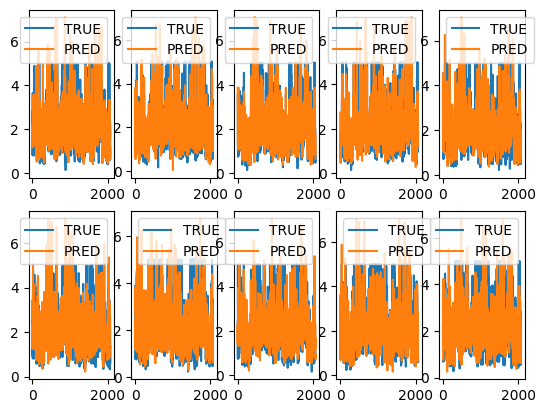


Method='gradient_descent':
	MSE: [0.6216, 0.5908, 0.6157, 0.5991, 0.5572, 0.6198, 0.5842, 0.5575, 0.6037, 0.5805]
	R2: [0.5376, 0.5623, 0.5489, 0.5467, 0.5617, 0.5569, 0.5615, 0.5695, 0.5631, 0.5347]


(0.593, 0.5543)

In [12]:
print("=====Kfold=====\n")
cross_val_score(lr, scaling_data, target, n_splits=10)

In [13]:
print("=====Compare=====\n")
compare_training_method(lr, scaling_data, target)

=====Compare=====


Method='normal_equation':
	MSE: [0.5451, 0.5233, 0.5377, 0.5172, 0.4901, 0.5383, 0.5234, 0.4791, 0.5551, 0.5787]
	R2: [0.5945, 0.6123, 0.606, 0.6087, 0.6145, 0.6152, 0.6072, 0.63, 0.5983, 0.5362]

Method='gradient_descent':
	MSE: [0.6216, 0.5908, 0.6157, 0.5991, 0.5572, 0.6198, 0.5842, 0.5575, 0.6037, 0.5805]
	R2: [0.5376, 0.5623, 0.5489, 0.5467, 0.5617, 0.5569, 0.5615, 0.5695, 0.5631, 0.5347]

Method='normal_equation_reg':
	MSE: [0.5533, 0.5343, 0.5492, 0.5308, 0.5049, 0.5492, 0.5349, 0.4894, 0.5555, 0.5358]
	R2: [0.5884, 0.6042, 0.5976, 0.5984, 0.6028, 0.6074, 0.5985, 0.6221, 0.598, 0.5706]

Method='gradient_descent_reg':
	MSE: [0.6218, 0.5913, 0.616, 0.5993, 0.5576, 0.6199, 0.5847, 0.558, 0.6041, 0.5808]
	R2: [0.5374, 0.5619, 0.5487, 0.5466, 0.5614, 0.5569, 0.5612, 0.5691, 0.5629, 0.5345]


Average Score (MSE_Loss, R2_score): 
{'normal_equation': (0.5288, 0.6023), 'gradient_descent': (0.593, 0.5543), 'normal_equation_reg': (0.5337, 0.5988), 'gradient_descent_reg'

NE_TEST

Method='normal_equation':
	MSE: [0.5451, 0.5233, 0.5377, 0.5172, 0.4901, 0.5383, 0.5234, 0.4791, 0.5551, 0.5787]
	R2: [0.5945, 0.6123, 0.606, 0.6087, 0.6145, 0.6152, 0.6072, 0.63, 0.5983, 0.5362]
(0.5288, 0.6023)

Method='normal_equation':
	MSE: [0.5451, 0.5233, 0.5377, 0.5172, 0.4901, 0.5383, 0.5234, 0.4791, 0.5551, 0.5787]
	R2: [0.5945, 0.6123, 0.606, 0.6087, 0.6145, 0.6152, 0.6072, 0.63, 0.5983, 0.5362]
(0.5288, 0.6023)

Method='normal_equation':
	MSE: [0.5451, 0.5233, 0.5377, 0.5172, 0.4901, 0.5383, 0.5234, 0.4791, 0.5551, 0.5787]
	R2: [0.5945, 0.6123, 0.606, 0.6087, 0.6145, 0.6152, 0.6072, 0.63, 0.5983, 0.5362]
(0.5288, 0.6023)
BGD-TEST


d:\Install\Anaconda\envs\ml-labs\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\Install\Anaconda\envs\ml-labs\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in power
d:\Install\Anaconda\envs\ml-labs\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
d:\Install\Anaconda\envs\ml-labs\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in subtract


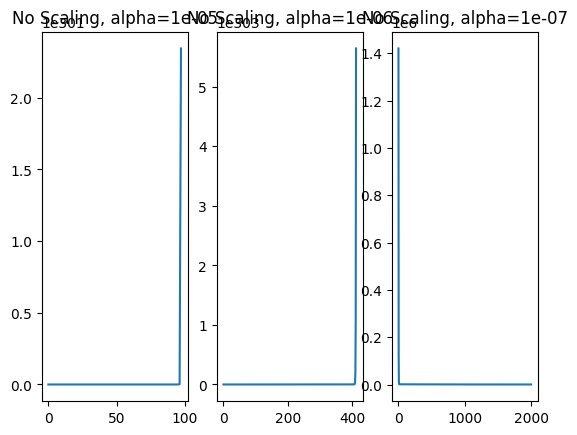

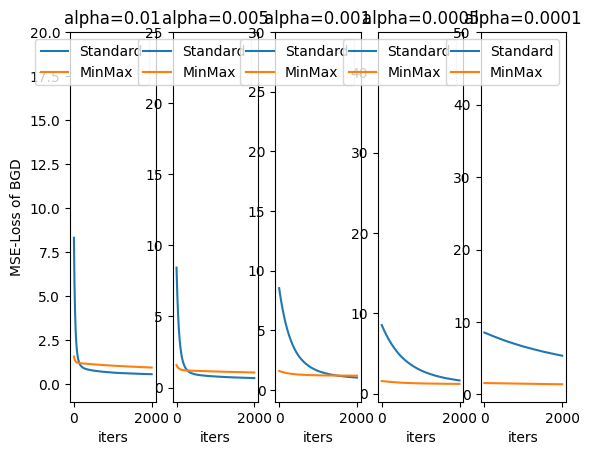

In [14]:
feature_scaling_test(lr, data, target)

=====draw=====



KeyboardInterrupt: 

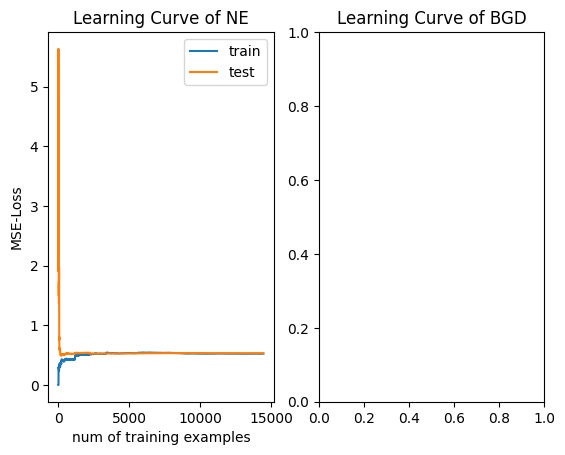

In [15]:
print("=====draw=====\n")
draw_learning_curve(lr, scaling_data, target)

=====lambda test=====



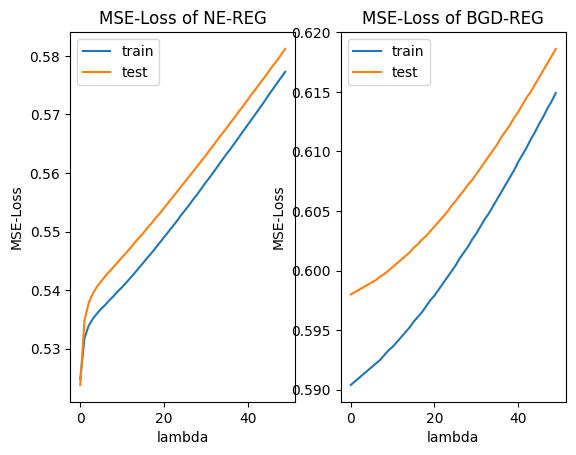

In [ ]:
print("=====lambda test=====\n")
lambda_test(lr, scaling_data, target)